# OpenAI GPT2

In [67]:
import pandas as pd
import numpy as np
import os
import tqdm

from PIL import Image
import matplotlib.pyplot as plt

In [68]:
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [69]:
pip install --upgrade huggingface_hub

Note: you may need to restart the kernel to use updated packages.


In [70]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

import torchvision
from torchvision import datasets, models, transforms
from torchvision.io import read_image, ImageReadMode
from torchvision.datasets import ImageFolder

from transformers import GPT2Tokenizer
from transformers import GPT2Config
from transformers import GPT2LMHeadModel
from transformers import AdamW

In [71]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU: Tesla P100-PCIE-16GB


## Dataset visualization

In [72]:
img_base_dir = '/kaggle/input/chest-xrays-indiana-university/images/images_normalized/'

In [73]:
reports_df = pd.read_csv('/kaggle/input/chest-xrays-indiana-university/indiana_reports.csv')
reports_df.head()

,uid,MeSH,Problems,image,indication,comparison,findings,impression
0,1,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.
1,2,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.
2,3,normal,normal,Xray Chest PA and Lateral,"rib pain after a XXXX, XXXX XXXX steps this XX...",NaN,NaN,"No displaced rib fractures, pneumothorax, or p..."
3,4,"Pulmonary Disease, Chronic Obstructive;Bullous...","Pulmonary Disease, Chronic Obstructive;Bullous...","PA and lateral views of the chest XXXX, XXXX a...",XXXX-year-old XXXX with XXXX.,None available,There are diffuse bilateral interstitial and a...,1. Bullous emphysema and interstitial fibrosis...
4,5,Osteophyte/thoracic vertebrae/multiple/small;T...,Osteophyte;Thickening;Lung,Xray Chest PA and Lateral,Chest and nasal congestion.,NaN,The cardiomediastinal silhouette and pulmonary...,No acute cardiopulmonary abnormality.


In [74]:
projections_df = pd.read_csv('/kaggle/input/chest-xrays-indiana-university/indiana_projections.csv')
projections_df.head()

,uid,filename,projection
0,1,1_IM-0001-4001.dcm.png,Frontal
1,1,1_IM-0001-3001.dcm.png,Lateral
2,2,2_IM-0652-1001.dcm.png,Frontal
3,2,2_IM-0652-2001.dcm.png,Lateral
4,3,3_IM-1384-1001.dcm.png,Frontal


In [75]:
reports_df.shape, projections_df.shape

((3851, 8), (7466, 3))

In [76]:
class ImageCaptionData:
    def __init__(self, reports_df, projections_df):
        self.reports_df = reports_df.set_index('uid')
        self.projections_df = projections_df.set_index('uid')
        self.uids = reports_df[reports_df.findings.notnull()].uid.unique()
        
    def get_sample(self):
        uid = np.random.choice(self.uids)
        images = list(self.projections_df.loc[[uid]]['filename'])
        projections = list(self.projections_df.loc[[uid]]['projection'])
        findings = self.reports_df.loc[uid]['findings']
        return uid, images, projections, findings

In [77]:
paired_dataset = ImageCaptionData(reports_df, projections_df)
uid, images, projections, findings = paired_dataset.get_sample()

In [78]:
def display_sample(uid, images, projections, findings):
    plt.figure(figsize=(10, 5))
    print("UID:", uid)
    for i, (img, proj) in enumerate(zip(images, projections)):
        plt.subplot(1, len(images), i+1)
        png_img = Image.open(os.path.join(img_base_dir, img))
        png_img = png_img.convert('RGB')
        plt.title(proj)
        plt.imshow(png_img)
        plt.axis('off')
    plt.show()
    print(f"Findings: {findings}")

In [ ]:
display_sample(uid, images, projections, findings)

UID: 3770


In [80]:
uids = projections_df.uid.unique()
train_uids, test_uids = train_test_split(uids, test_size=0.1, random_state=42)

In [81]:
len(train_uids), len(test_uids)

(3465, 386)

## Setting up Language Model

In [82]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

In [83]:
findings_corpus = [tokenizer.encode(line) for line in reports_df[reports_df.uid.isin(train_uids)].findings.dropna()]

In [84]:
pd.Series([len(x) for x in findings_corpus]).describe(percentiles=[0.25, 0.5, 0.75, 0.8, 0.9, 0.95])

count    3003.000000
mean       51.048618
std        22.007258
min         8.000000
25%        37.000000
50%        48.000000
75%        61.000000
80%        67.000000
90%        80.000000
95%        92.000000
max       238.000000
dtype: float64

In [85]:
class GPT2Dataset(Dataset):
    def __init__(self, txt_list, max_length):
        self.input_ids = [torch.tensor(t[:max_length-1] + [tokenizer.eos_token_id]) for t in txt_list]

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, index):
        return self.input_ids[index]

In [86]:
def collate_batch(batch):
    """
    Pad the batch to ensure all sequences have the same length.
    """
    pad_id = tokenizer.pad_token_id
    if pad_id is None:
        pad_id = tokenizer.eos_token_id
    return pad_sequence(batch, batch_first=True, padding_value=pad_id)

In [87]:
# Create dataset
dataset = GPT2Dataset(findings_corpus, max_length=128)  # Adjust max_length as needed
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=collate_batch)

In [88]:
model = GPT2LMHeadModel.from_pretrained('gpt2')
model = model.to(device)

In [89]:
sample_reports = list(reports_df[reports_df.uid.isin(test_uids)].findings.dropna().sample(5))

In [90]:
model.eval()
generated_texts = []
with torch.no_grad():
    for smp_report in sample_reports:
        prompt_text = " ".join(smp_report.split()[:5])
        encoded_input = tokenizer.encode(prompt_text, return_tensors='pt')
        encoded_input = encoded_input.to(device) 
        generated_sequences = model.generate(
            input_ids = encoded_input,
            max_length = 100,  # Total length of output text (including the prompt)
            num_return_sequences = 1,  # Number of sequences to generate
            temperature = 0.7,  # Sampling temperature
            top_k = 50,  # Top-k filtering
            top_p = 0.95,  # Top-p (nucleus) filtering
            no_repeat_ngram_size = 2,  # Prevent repetitions of n-grams
            pad_token_id = tokenizer.eos_token_id
        )
        generated_text = tokenizer.decode(generated_sequences[0], skip_special_tokens=True)
        generated_texts.append(generated_text)

In [91]:
!pip install -U nltk
!pip install rouge_score bert_score -q

In [92]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
from bert_score import score as bert_score

import nltk
nltk.download('wordnet', download_dir='/usr/local/share/nltk_data')

[nltk_data] Downloading package wordnet to
[nltk_data]     /usr/local/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [93]:
# Инициализация скореров
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
smoothie = SmoothingFunction().method4

# Расчет метрик для каждой пары сгенерированного и исходного текста
for smp, gen in zip(sample_reports, generated_texts):
    print("Sample report:\n", smp)
    print("Generated report:\n", gen)
    
    # BLEU
    for i in range(1, 5):
        weights = [1/i]*i + [0]*(4-i)  # weights for 1-gram to 4-gram
        bleu_score = sentence_bleu([smp.split()], gen.split(), weights=weights, smoothing_function=smoothie)
        print(f"BLEU-{i} score:", bleu_score)

    # ROUGE
    scores = scorer.score(smp, gen)
    print("ROUGE-1: ", scores['rouge1'])
    print("ROUGE-2: ", scores['rouge2'])
    print("ROUGE-L: ", scores['rougeL'])
    
    # BERTScore
    P, R, F1 = bert_score([gen], [smp], lang="en")
    print("BERTScore: ", F1.item())

    print("------------")


Sample report:
 Right central venous line has been removed. Heart size and pulmonary vascularity appear within normal limits. A few bandlike opacities are present at the lateral left base. The appearance XXXX scarring or atelectasis. No focal airspace disease is seen. No discrete nodules are identified. No pneumothorax or pleural effusion is seen.
Generated report:
 Right central venous line has been established in the blood of the patient. The blood is drawn from the right side of his body.

The blood drawn is then taken to the left side and the veno- venal line is established. This is the point where the arterial blood flow is measured. It is important to note that the number of blood vessels in a patient is not always the same as the amount of arterially drawn blood. In some cases, the total number is greater
BLEU-1 score: 0.13953488372093023
BLEU-2 score: 0.09059765083337044
BLEU-3 score: 0.07311472646534814
BLEU-4 score: 0.06130761694893939
ROUGE-1:  Score(precision=0.151162790697

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERTScore:  0.8240680694580078
------------
Sample report:
 XXXX XXXX and lateral chest examination was obtained. There is enlarged heart silhouette. Decreased lung volumes. Lungs demonstrate bibasilar airspace opacities better visualized on lateral view. There is no effusion or pneumothorax. Degenerative changes of the bilateral XXXX.
Generated report:
 XXXX XXXX and lateral chest xxx.

The first two rows of the chart are the same as the first row of this chart. The third row is the one that is not shown. This is because the second row has a different height than the third. In this case, the height of each row will be the width of that row. If the row width is less than or equal to the length of a row, then the column width will not be equal. For example, if
BLEU-1 score: 0.11494252873563215
BLEU-2 score: 0.08174781439921426
BLEU-3 score: 0.061785259702997364
BLEU-4 score: 0.048680085772601404
ROUGE-1:  Score(precision=0.11494252873563218, recall=0.2631578947368421, fmeasure=0.16)
ROU

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERTScore:  0.8238091468811035
------------
Sample report:
 The cardiomediastinal silhouette is within normal limits for appearance. The thoracic aorta is calcified. No focal areas of pulmonary consolidation. No pneumothorax. No pleural effusion. Minimal osteophytes of the thoracic spine. No acute, displaced rib fractures. A calcified granuloma is demonstrated in the left upper lobe.
Generated report:
 The cardiomediastinal silhouette is within striking distance of the heart. The cardiopulmonary system is the most important organ in the body. It is responsible for the development of heart and lung function.

The heart is a vital organ that is involved in many functions. Heart function is important for many reasons. For example, it is vital for heart function in people with diabetes, heart disease, and cancer. In addition, the cardiac system plays a role in regulating the blood
BLEU-1 score: 0.17721518987341772
BLEU-2 score: 0.1167558892843123
BLEU-3 score: 0.08098340640452352
BLEU-4 sc

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERTScore:  0.8263365626335144
------------
Sample report:
 Heart size within normal limits. No focal alveolar consolidation, no definite pleural effusion seen. No typical findings of pulmonary edema. No pneumothorax.
Generated report:
 Heart size within normal limits.

The following table lists the maximum number of cells in the body that can be used to create a new cell. The cells are listed in order of their size. If you want to see the size of a cell, click on the cell name. For example, if you have a size 1 cell that is 1.5 inches long, you can create an 8-cell cell by clicking on a 1-inch-long cell and selecting the "Size 1"
BLEU-1 score: 0.07407407407407407
BLEU-2 score: 0.06085806194501848
BLEU-3 score: 0.052004804300939254
BLEU-4 score: 0.043577915062129664
ROUGE-1:  Score(precision=0.07058823529411765, recall=0.2727272727272727, fmeasure=0.11214953271028037)
ROUGE-2:  Score(precision=0.047619047619047616, recall=0.19047619047619047, fmeasure=0.07619047619047618)
ROUGE-L:  Sco

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERTScore:  0.8174138069152832
------------
Sample report:
 The cardiomediastinal silhouette is within normal limits for size and contour. The lungs are normally inflated without evidence of focal airspace disease, pleural effusion, or pneumothorax. No acute bone abnormality.
Generated report:
 The cardiomediastinal silhouette is within striking distance of the heart. The cardiopulmonary system is the most important organ in the body. It is responsible for the development of heart and lung function.

The heart is a vital organ that is involved in many functions. Heart function is important for many reasons. For example, it is vital for heart function in people with diabetes, heart disease, and cancer. In addition, the cardiac system plays a role in regulating the blood
BLEU-1 score: 0.1265822784810127
BLEU-2 score: 0.08056921804549294
BLEU-3 score: 0.06323967203176727
BLEU-4 score: 0.05079211619319862
ROUGE-1:  Score(precision=0.13924050632911392, recall=0.36666666666666664, fmeasure=0

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERTScore:  0.8377253413200378
------------


In [94]:
model.train()
optimizer = AdamW(model.parameters(), lr=5e-5)

NUM_EPOCHS = 3
for epoch in range(NUM_EPOCHS):
    for batch in tqdm.auto.tqdm(dataloader):
        optimizer.zero_grad()
        outputs = model(batch.to(device), labels=batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch} completed')

  0%|          | 0/751 [00:00<?, ?it/s]

Epoch 0 completed


  0%|          | 0/751 [00:00<?, ?it/s]

Epoch 1 completed


  0%|          | 0/751 [00:00<?, ?it/s]

Epoch 2 completed


In [95]:
model.eval()
generated_texts = []
with torch.no_grad():
    for smp_report in sample_reports:
        prompt_text = " ".join(smp_report.split()[:5])
        encoded_input = tokenizer.encode(prompt_text, return_tensors='pt')
        encoded_input = encoded_input.to(device) 
        generated_sequences = model.generate(
            input_ids = encoded_input,
            max_length = 100,  # Total length of output text (including the prompt)
            num_return_sequences = 1,  # Number of sequences to generate
            temperature = 0.7,  # Sampling temperature
            top_k = 50,  # Top-k filtering
            top_p = 0.95,  # Top-p (nucleus) filtering
            no_repeat_ngram_size = 2,  # Prevent repetitions of n-grams
            pad_token_id = tokenizer.eos_token_id
        )
        generated_text = tokenizer.decode(generated_sequences[0], skip_special_tokens=True)
        generated_texts.append(generated_text)
for smp, gen in zip(sample_reports, generated_texts):
    print("Sample report:\n", smp)
    print("Generated report:\n", gen)
    print("------------")

Sample report:
 Right central venous line has been removed. Heart size and pulmonary vascularity appear within normal limits. A few bandlike opacities are present at the lateral left base. The appearance XXXX scarring or atelectasis. No focal airspace disease is seen. No discrete nodules are identified. No pneumothorax or pleural effusion is seen.
Generated report:
 Right central venous line has been removed. No pneumothorax or pleural effusion. Heart size and mediastinal contour are within normal limits.
------------
Sample report:
 XXXX XXXX and lateral chest examination was obtained. There is enlarged heart silhouette. Decreased lung volumes. Lungs demonstrate bibasilar airspace opacities better visualized on lateral view. There is no effusion or pneumothorax. Degenerative changes of the bilateral XXXX.
Generated report:
 XXXX XXXX and lateral chest examination was obtained. The heart silhouette is normal in size and contour. There is no mediastinal widening. No large pleural effusi

In [96]:
# Инициализация скореров
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
smoothie = SmoothingFunction().method4

# Расчет метрик для каждой пары сгенерированного и исходного текста
for smp, gen in zip(sample_reports, generated_texts):
    print("Sample report:\n", smp)
    print("Generated report:\n", gen)
    
    # BLEU
    for i in range(1, 5):
        weights = [1/i]*i + [0]*(4-i)  # weights for 1-gram to 4-gram
        bleu_score = sentence_bleu([smp.split()], gen.split(), weights=weights, smoothing_function=smoothie)
        print(f"BLEU-{i} score:", bleu_score)

    # ROUGE
    scores = scorer.score(smp, gen)
    print("ROUGE-1: ", scores['rouge1'])
    print("ROUGE-2: ", scores['rouge2'])
    print("ROUGE-L: ", scores['rougeL'])
    
    # BERTScore
    P, R, F1 = bert_score([gen], [smp], lang="en")
    print("BERTScore: ", F1.item())

    print("------------")

Sample report:
 Right central venous line has been removed. Heart size and pulmonary vascularity appear within normal limits. A few bandlike opacities are present at the lateral left base. The appearance XXXX scarring or atelectasis. No focal airspace disease is seen. No discrete nodules are identified. No pneumothorax or pleural effusion is seen.
Generated report:
 Right central venous line has been removed. No pneumothorax or pleural effusion. Heart size and mediastinal contour are within normal limits.
BLEU-1 score: 0.2054151740929507
BLEU-2 score: 0.17888033316146928
BLEU-3 score: 0.1537202693377755
BLEU-4 score: 0.12470031635453958
ROUGE-1:  Score(precision=0.9047619047619048, recall=0.37254901960784315, fmeasure=0.5277777777777779)
ROUGE-2:  Score(precision=0.7, recall=0.28, fmeasure=0.4)
ROUGE-L:  Score(precision=0.6190476190476191, recall=0.2549019607843137, fmeasure=0.3611111111111111)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERTScore:  0.9071776866912842
------------
Sample report:
 XXXX XXXX and lateral chest examination was obtained. There is enlarged heart silhouette. Decreased lung volumes. Lungs demonstrate bibasilar airspace opacities better visualized on lateral view. There is no effusion or pneumothorax. Degenerative changes of the bilateral XXXX.
Generated report:
 XXXX XXXX and lateral chest examination was obtained. The heart silhouette is normal in size and contour. There is no mediastinal widening. No large pleural effusion or pneumothorax.
BLEU-1 score: 0.3998128785000744
BLEU-2 score: 0.3375905367140308
BLEU-3 score: 0.2905788484439347
BLEU-4 score: 0.24206344212966524
ROUGE-1:  Score(precision=0.6428571428571429, recall=0.47368421052631576, fmeasure=0.5454545454545454)
ROUGE-2:  Score(precision=0.4444444444444444, recall=0.32432432432432434, fmeasure=0.375)
ROUGE-L:  Score(precision=0.5714285714285714, recall=0.42105263157894735, fmeasure=0.48484848484848486)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERTScore:  0.9078986048698425
------------
Sample report:
 The cardiomediastinal silhouette is within normal limits for appearance. The thoracic aorta is calcified. No focal areas of pulmonary consolidation. No pneumothorax. No pleural effusion. Minimal osteophytes of the thoracic spine. No acute, displaced rib fractures. A calcified granuloma is demonstrated in the left upper lobe.
Generated report:
 The cardiomediastinal silhouette is within normal limits for size and contour. The lungs are normally inflated without evidence of focal airspace disease, pleural effusion, or pneumothorax. Osseous structures are within the normal patient limits.
BLEU-1 score: 0.28931350933182165
BLEU-2 score: 0.20765204094555512
BLEU-3 score: 0.17842858233294323
BLEU-4 score: 0.15928698609387015
ROUGE-1:  Score(precision=0.4411764705882353, recall=0.32608695652173914, fmeasure=0.375)
ROUGE-2:  Score(precision=0.24242424242424243, recall=0.17777777777777778, fmeasure=0.20512820512820512)
ROUGE-L:  Score(

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERTScore:  0.8952119946479797
------------
Sample report:
 Heart size within normal limits. No focal alveolar consolidation, no definite pleural effusion seen. No typical findings of pulmonary edema. No pneumothorax.
Generated report:
 Heart size within normal limits. No focal airspace consolidations. Mild degenerative changes of the thoracic spine.
BLEU-1 score: 0.3436446393954861
BLEU-2 score: 0.3073651095166837
BLEU-3 score: 0.2851654398194491
BLEU-4 score: 0.26462856400352447
ROUGE-1:  Score(precision=0.5625, recall=0.4090909090909091, fmeasure=0.47368421052631576)
ROUGE-2:  Score(precision=0.4, recall=0.2857142857142857, fmeasure=0.3333333333333333)
ROUGE-L:  Score(precision=0.5625, recall=0.4090909090909091, fmeasure=0.47368421052631576)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERTScore:  0.9037311673164368
------------
Sample report:
 The cardiomediastinal silhouette is within normal limits for size and contour. The lungs are normally inflated without evidence of focal airspace disease, pleural effusion, or pneumothorax. No acute bone abnormality.
Generated report:
 The cardiomediastinal silhouette is within normal limits for size and contour. The lungs are normally inflated without evidence of focal airspace disease, pleural effusion, or pneumothorax. Osseous structures are within the normal patient limits.
BLEU-1 score: 0.7647058823529411
BLEU-2 score: 0.7611324708263125
BLEU-3 score: 0.7574034070197264
BLEU-4 score: 0.7535064536537183
ROUGE-1:  Score(precision=0.7647058823529411, recall=0.8666666666666667, fmeasure=0.8125)
ROUGE-2:  Score(precision=0.7575757575757576, recall=0.8620689655172413, fmeasure=0.8064516129032258)
ROUGE-L:  Score(precision=0.7647058823529411, recall=0.8666666666666667, fmeasure=0.8125)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERTScore:  0.9702216982841492
------------


In [97]:
model.save_pretrained('/kaggle/working/gpt-2-model')
tokenizer.save_pretrained('/kaggle/working/gpt-2-tokenizer')

('/kaggle/working/gpt-2-tokenizer/tokenizer_config.json',
 '/kaggle/working/gpt-2-tokenizer/special_tokens_map.json',
 '/kaggle/working/gpt-2-tokenizer/vocab.json',
 '/kaggle/working/gpt-2-tokenizer/merges.txt',
 '/kaggle/working/gpt-2-tokenizer/added_tokens.json')

## Setting up Joint Model

In [98]:
tokenizer = GPT2Tokenizer.from_pretrained('/kaggle/working/gpt-2-tokenizer')
vision_preprocess = models.swin_transformer.Swin_T_Weights.IMAGENET1K_V1.transforms()

In [99]:
MAX_SEQ_LENGTH  = 128
MAX_IMG_STACK = 5 + 1
BATCH_SIZE = 4

In [100]:
class ImageCaptionData(Dataset):
    def __init__(self, reports_df, projections_df, max_length=MAX_SEQ_LENGTH, max_img_stack=MAX_IMG_STACK):
        self.reports_df = reports_df.dropna(subset={'findings'}).set_index('uid')
        self.projections_df = projections_df.set_index('uid')
        self.uids = list(set(self.reports_df.index).intersection(self.projections_df.index))
        self.max_length = max_length
        self.max_img_stack = max_img_stack
        
    def __getitem__(self, index):
        uid = self.uids[index]
        image_paths = [os.path.join(img_base_dir, x) for x in list(self.projections_df.loc[[uid]]['filename'])]
        images = torch.stack([vision_preprocess(read_image(img ,ImageReadMode.RGB)) for img in image_paths])
        len_image_stack = len(image_paths)
        img_dim = images[0].shape
        images = torch.cat((torch.zeros((self.max_img_stack - len_image_stack, *img_dim)), images), dim=0)
        
        findings = tokenizer.encode(self.reports_df.loc[uid]['findings'])
        findings = torch.tensor(findings[:self.max_length-1] + [tokenizer.eos_token_id])
        return len_image_stack, images, findings
    
    def __len__(self):
        return len(self.uids)

In [101]:
def collate_batch(batch):
    """
    Pad the batch to ensure all sequences have the same length.
    """
    len_images = torch.tensor([item[0] for item in batch])
    img_data = torch.stack([item[1] for item in batch])
    pad_id = tokenizer.pad_token_id
    if pad_id is None:
        pad_id = tokenizer.eos_token_id
        
    tokens = pad_sequence([item[2] for item in batch], batch_first=True, padding_value=pad_id)
    labels = pad_sequence([torch.cat((torch.tensor([-100]*MAX_IMG_STACK), item[2])) for item in batch], batch_first=True, padding_value=pad_id) 
    return [len_images, img_data, tokens, labels, pad_sequence([torch.ones(len(item[2])+MAX_IMG_STACK) for item in batch], batch_first=True, padding_value=0)]

In [102]:
train_dataset = ImageCaptionData(reports_df[reports_df.uid.isin(train_uids)], projections_df[projections_df.uid.isin(train_uids)])
test_dataset = ImageCaptionData(reports_df[~reports_df.uid.isin(train_uids)], projections_df[~projections_df.uid.isin(train_uids)])

In [103]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)

In [104]:
x = next(iter(train_dataloader))
x[0].shape, x[1].shape, x[2].shape, x[3].shape, x[4].shape

(torch.Size([4]),
 torch.Size([4, 6, 3, 224, 224]),
 torch.Size([4, 57]),
 torch.Size([4, 63]),
 torch.Size([4, 63]))

In [105]:
lang_model = GPT2LMHeadModel.from_pretrained('/kaggle/working/gpt-2-model')

In [106]:
vision_model = models.swin_t(weights=models.swin_transformer.Swin_T_Weights.DEFAULT)
vision_model.head = nn.Identity() # strip off classification layer of swin transformer to get the image embedding

In [107]:
VISION_MODEL_OUTPUT_DIM = 768
LANG_MODEL_INPUT_DIM = 768

In [108]:
class ProjectionModel(nn.Module):
    def __init__(self, vision_out_dim, lang_inp_dim):
        super(ProjectionModel, self).__init__()
        self.lin = nn.Linear(vision_out_dim, lang_inp_dim, bias=True)
    
    def forward(self, x):
        x = nn.functional.tanh(self.lin(x))
        return x

In [109]:
projection_model = ProjectionModel(VISION_MODEL_OUTPUT_DIM, LANG_MODEL_INPUT_DIM)

In [110]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [111]:
vision_model = vision_model.to(device)
lang_model = lang_model.to(device)
projection_model = projection_model.to(device)

In [112]:
# freeze vision model
vision_model.eval()
for param in vision_model.parameters():
    param.requires_grad = False

In [113]:
optimizer = torch.optim.Adam([
    {"params": lang_model.parameters(), "lr": 2e-5},
    {"params": projection_model.parameters(), "lr": 5e-5},
    {"params": vision_model.parameters(), "lr": 1e-5}  # Добавьте vision encoder
])

In [114]:
NUM_EPOCHS = 5

In [115]:
MODEL_CHECKPOINTS_PATH = '/kaggle/working/checkpoints'
if not os.path.exists(MODEL_CHECKPOINTS_PATH):
    os.makedirs(MODEL_CHECKPOINTS_PATH)

In [116]:
import pdb

In [117]:
best_val_loss = np.inf

In [118]:
train_loss = []
for i in range(NUM_EPOCHS):
    train_batch_loss = []
    
    lang_model.train()
    projection_model.train()
    for l_img, img, tokens, labels, attn in tqdm.auto.tqdm(train_dataloader):
        img, tokens, labels, attn = img.to(device), tokens.to(device), labels.to(device), attn.to(device)
        optimizer.zero_grad()
        with torch.no_grad():
            # refetching bos_embedding to handle cases where bos_embedding might be trainable as well
            bos_embedding = lang_model.get_input_embeddings()(torch.tensor([tokenizer.bos_token_id]*MAX_IMG_STACK).to(device))
            bos_embedding = torch.stack([bos_embedding]*len(l_img))
            mask = torch.stack([torch.cat([torch.ones(MAX_IMG_STACK-limg), torch.zeros(limg)]).repeat(LANG_MODEL_INPUT_DIM,1).T for limg in l_img]).to(device)
            img_embed = vision_model(img.flatten(0, 1))
        
        img_embed = projection_model(img_embed).reshape(len(l_img), MAX_IMG_STACK, LANG_MODEL_INPUT_DIM)
        img_embed = bos_embedding*mask + (1-mask)*img_embed # replace images that are not present with bos embedding

        tok_embed = lang_model.get_input_embeddings()(tokens)
        input_embed = torch.cat((img_embed, tok_embed), dim=1)
        outputs = lang_model(
                inputs_embeds=input_embed,
                labels=labels,
                attention_mask=attn,
            )

        loss = outputs.loss
        loss.backward()
        optimizer.step()
        train_batch_loss.append(loss.item() / len(l_img))
        
    train_loss.append(train_batch_loss)
    
    lang_model.eval()
    projection_model.eval()
    aggregated_val_loss = []
    with torch.no_grad():
        for l_img, img, tokens, labels, attn in tqdm.auto.tqdm(test_dataloader):
            img, tokens, labels, attn = img.to(device), tokens.to(device), labels.to(device), attn.to(device)
            
            bos_embedding = lang_model.get_input_embeddings()(torch.tensor([tokenizer.bos_token_id] * MAX_IMG_STACK).to(device))
            bos_embedding = torch.stack([bos_embedding] * len(l_img))
            mask = torch.stack([torch.cat([torch.ones(MAX_IMG_STACK - limg), torch.zeros(limg)]).repeat(LANG_MODEL_INPUT_DIM, 1).T for limg in l_img]).to(device)
            img_embed = vision_model(img.flatten(0, 1))
        
            img_embed = projection_model(img_embed).reshape(len(l_img), MAX_IMG_STACK, LANG_MODEL_INPUT_DIM)
            img_embed = bos_embedding * mask + (1 - mask) * img_embed

            tok_embed = lang_model.get_input_embeddings()(tokens)
            input_embed = torch.cat((img_embed, tok_embed), dim=1)
            outputs = lang_model(
                    inputs_embeds=input_embed,
                    labels=labels,
                    attention_mask=attn,
                )

            loss = outputs.loss
            aggregated_val_loss.append(loss.item() / len(l_img))
    
    print("Epoch:", i, "Train Loss: {:.4f}".format(np.mean(train_batch_loss)), "Val Loss: {:.4f}".format(np.mean(aggregated_val_loss)))
    if (np.mean(aggregated_val_loss) < best_val_loss):
        best_val_loss = np.mean(aggregated_val_loss)
        epoch_checkpoint_path = os.path.join(MODEL_CHECKPOINTS_PATH, 'epoch_' + str(i))
        if not os.path.exists(epoch_checkpoint_path):
            os.makedirs(epoch_checkpoint_path)
        model.save_pretrained(os.path.join(epoch_checkpoint_path, 'gpt-2-model'))
        tokenizer.save_pretrained(os.path.join(epoch_checkpoint_path, 'gpt-2-tokenizer'))
        torch.save(projection_model.state_dict(), os.path.join(epoch_checkpoint_path, 'projection_model.pth'))
        print(f"Saved checkpoint at {epoch_checkpoint_path}")

  0%|          | 0/751 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch: 0 Train Loss: 0.1660 Val Loss: 0.1661
Saved checkpoint at /kaggle/working/checkpoints/epoch_0


  0%|          | 0/751 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch: 1 Train Loss: 0.1531 Val Loss: 0.1629
Saved checkpoint at /kaggle/working/checkpoints/epoch_1


  0%|          | 0/751 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch: 2 Train Loss: 0.1460 Val Loss: 0.1635


  0%|          | 0/751 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch: 3 Train Loss: 0.1377 Val Loss: 0.1623
Saved checkpoint at /kaggle/working/checkpoints/epoch_3


  0%|          | 0/751 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch: 4 Train Loss: 0.1319 Val Loss: 0.1617
Saved checkpoint at /kaggle/working/checkpoints/epoch_4


In [53]:
for param_group in optimizer.param_groups:
    param_group['lr'] = param_group['lr']*0.2

## Evaluation Mode

In [54]:
BEST_CHECKPOINT_PATH = "/kaggle/working/checkpoints/epoch_2/"
BEST_CHECKPOINT_PATH = epoch_checkpoint_path

In [55]:
os.listdir(BEST_CHECKPOINT_PATH)
# os.listdir(os.path.join(BEST_CHECKPOINT_PATH, 'gpt-2-model'))

['gpt-2-model', 'projection_model.pth', 'gpt-2-tokenizer']

In [56]:
VISION_MODEL_OUTPUT_DIM = 768
LANG_MODEL_INPUT_DIM = 768

class ProjectionModel(nn.Module):
    def __init__(self, vision_out_dim, lang_inp_dim):
        super(ProjectionModel, self).__init__()
        self.lin = nn.Linear(vision_out_dim, lang_inp_dim, bias=True)
    
    def forward(self, x):
        x = nn.functional.tanh(self.lin(x))
        return x

In [57]:
def load_best_checkpoint(checkpoint_path):
    vision_preprocess = models.swin_transformer.Swin_T_Weights.IMAGENET1K_V1.transforms()
    
    lang_model = GPT2LMHeadModel.from_pretrained(os.path.join(checkpoint_path, 'gpt-2-model'))
    tokenizer = GPT2Tokenizer.from_pretrained(os.path.join(checkpoint_path, 'gpt-2-tokenizer'))
    
    projection_model = ProjectionModel(VISION_MODEL_OUTPUT_DIM, LANG_MODEL_INPUT_DIM)
    projection_model.load_state_dict(torch.load(os.path.join(checkpoint_path, 'projection_model.pth')))
    
    vision_model = models.swin_t(weights=models.swin_transformer.Swin_T_Weights.DEFAULT)
    vision_model.head = nn.Identity()
    
    vision_model.eval()
    projection_model.eval()
    lang_model.eval()
    return vision_model, projection_model, lang_model, tokenizer, vision_preprocess

In [58]:
vision_model, projection_model, lang_model, tokenizer, vision_preprocess = load_best_checkpoint(BEST_CHECKPOINT_PATH)

In [59]:
vision_model = vision_model.to(device)
lang_model = lang_model.to(device)
projection_model = projection_model.to(device)

In [60]:
def generate_report(image_paths):
    images = torch.stack([vision_preprocess(read_image(img,ImageReadMode.RGB)) for img in image_paths])
    len_image_stack = len(image_paths)

    with torch.no_grad():
        img_embed = vision_model(images.to(device))
        img_embed = projection_model(img_embed)

        # I found that padding here with bos token was actually causing issue with generation
        # probably because for gpt-2 bos_token=eos_token
        padded_img_embed = torch.cat([lang_model.get_input_embeddings()(torch.tensor([tokenizer.bos_token_id]*(MAX_IMG_STACK-len_image_stack)).to(device)), img_embed])

        generate_config = {
                    "eos_token_id": tokenizer.eos_token_id,
                    "bos_token_id": tokenizer.bos_token_id,
                    "pad_token_id": tokenizer.bos_token_id,
                    "max_new_tokens": 100,
                }

        output_ids = lang_model.generate(
            inputs_embeds=img_embed.unsqueeze(0), **generate_config
        )
    return tokenizer.batch_decode(output_ids, skip_special_tokens=True)[0]

In [61]:
# Инициализация скореров
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
smoothie = SmoothingFunction().method4

# Расчет метрик для каждой пары сгенерированного и исходного текста
for smp, gen in zip(sample_reports, generated_texts):
    print("Sample report:\n", smp)
    print("Generated report:\n", gen)
    
    # BLEU
    for i in range(1, 5):
        weights = [1/i]*i + [0]*(4-i)  # weights for 1-gram to 4-gram
        bleu_score = sentence_bleu([smp.split()], gen.split(), weights=weights, smoothing_function=smoothie)
        print(f"BLEU-{i} score:", bleu_score)

    # ROUGE
    scores = scorer.score(smp, gen)
    print("ROUGE-1: ", scores['rouge1'])
    print("ROUGE-2: ", scores['rouge2'])
    print("ROUGE-L: ", scores['rougeL'])
    
    # BERTScore
    P, R, F1 = bert_score([gen], [smp], lang="en")
    print("BERTScore: ", F1.item())

    print("------------")

Sample report:
 There extremely low lung volumes. there is right basilar opacity. There is no pneumothorax. There is no large pleural effusion. Cardiac silhouette and mediastinal contours are within normal limits.
Generated report:
 There extremely low lung volumes. There is no focal airspace consolidation. No pleural effusion or pneumothorax. Heart size is normal. The cardiomediastinal silhouette is grossly unremarkable.
BLEU-1 score: 0.44551168834777816
BLEU-2 score: 0.30865955183365723
BLEU-3 score: 0.24186095505002977
BLEU-4 score: 0.18195841162284612
ROUGE-1:  Score(precision=0.6153846153846154, recall=0.5517241379310345, fmeasure=0.5818181818181819)
ROUGE-2:  Score(precision=0.32, recall=0.2857142857142857, fmeasure=0.30188679245283023)
ROUGE-L:  Score(precision=0.46153846153846156, recall=0.41379310344827586, fmeasure=0.43636363636363634)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERTScore:  0.9252055287361145
------------
Sample report:
 The cardiac silhouette is borderline enlarged. Otherwise, there is no focal opacity. Mediastinal contours are within normal limits. There is no large pleural effusion. No pneumothorax.
Generated report:
 The cardiac silhouette is borderline enlarged. The mediastinum is unremarkable. There is no pleural effusion or pneumothorax.
BLEU-1 score: 0.4157303362945084
BLEU-2 score: 0.32729139180990363
BLEU-3 score: 0.27602119665310415
BLEU-4 score: 0.22697340794651855
ROUGE-1:  Score(precision=0.7647058823529411, recall=0.5, fmeasure=0.6046511627906976)
ROUGE-2:  Score(precision=0.5, recall=0.32, fmeasure=0.39024390243902435)
ROUGE-L:  Score(precision=0.7647058823529411, recall=0.5, fmeasure=0.6046511627906976)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERTScore:  0.9438673853874207
------------
Sample report:
 Lungs are clear bilaterally. Cardiac and mediastinal silhouettes are normal. Pulmonary vasculature is normal. No pneumothorax or pleural effusion. No acute bony abnormality.
Generated report:
 Lungs are clear bilaterally. Cardiac and mediastinal silhouettes are normal. Pulmonary vasculature is normal in caliber. No pneumothorax or pleural effusion. Minimal degenerative changes of the thoracic spine.
BLEU-1 score: 0.6428571428571429
BLEU-2 score: 0.6172133998483676
BLEU-3 score: 0.5897597462169347
BLEU-4 score: 0.5601658827714291
ROUGE-1:  Score(precision=0.6785714285714286, recall=0.8260869565217391, fmeasure=0.7450980392156864)
ROUGE-2:  Score(precision=0.6296296296296297, recall=0.7727272727272727, fmeasure=0.6938775510204083)
ROUGE-L:  Score(precision=0.6785714285714286, recall=0.8260869565217391, fmeasure=0.7450980392156864)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERTScore:  0.9597668051719666
------------
Sample report:
 The trachea is midline. The cardiomediastinal silhouette is normal. The lungs are clear, without evidence of acute infiltrate or effusion. There is no evidence of tuberculous disease. There is no pneumothorax. Visualized bony structures reveal no acute abnormalities.
Generated report:
 The trachea is midline. The cardiomediastinal silhouette is normal. There is no pneumothorax or large pleural effusion.
BLEU-1 score: 0.2394405467258709
BLEU-2 score: 0.208592239582924
BLEU-3 score: 0.18896057466281418
BLEU-4 score: 0.17028008164945987
ROUGE-1:  Score(precision=0.8823529411764706, recall=0.39473684210526316, fmeasure=0.5454545454545454)
ROUGE-2:  Score(precision=0.6875, recall=0.2972972972972973, fmeasure=0.41509433962264153)
ROUGE-L:  Score(precision=0.7647058823529411, recall=0.34210526315789475, fmeasure=0.4727272727272727)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERTScore:  0.942329466342926
------------
Sample report:
 Cardiomediastinal silhouettes are within normal limits. Lungs are clear without focal consolidation, pneumothorax, or pleural effusion. Vague nodular density right upper lobe overlying the right anterior 2nd and posterior 6th ribs. This could represent healing fracture or superimposed structures. Bony thorax is unremarkable.
Generated report:
 Cardiomediastinal silhouettes are within normal limits. Lungs are clear without focal consolidation, pneumothorax, or pleural effusion. Bony thorax is unremarkable.
BLEU-1 score: 0.3166367693790533
BLEU-2 score: 0.3081916002655412
BLEU-3 score: 0.29900845781777435
BLEU-4 score: 0.28895001397837444
ROUGE-1:  Score(precision=1.0, recall=0.46511627906976744, fmeasure=0.6349206349206349)
ROUGE-2:  Score(precision=0.9473684210526315, recall=0.42857142857142855, fmeasure=0.5901639344262295)
ROUGE-L:  Score(precision=1.0, recall=0.46511627906976744, fmeasure=0.6349206349206349)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERTScore:  0.9467719793319702
------------


новый код

In [62]:
# обновил вычисление метрик
def compare_report(uid):
#     print("Patient UID:", uid)
    
    uid_projection_df = projections_df[projections_df.uid==uid]
    image_paths = [os.path.join(img_base_dir, img_path) for img_path in uid_projection_df.filename]
    findings = reports_df[reports_df.uid==uid].findings.iloc[0]
    
    plt.figure(figsize=(10, 5))
    for i, (img, proj) in enumerate(zip(image_paths, list(uid_projection_df.projection))):
        if len(image_paths) > 1:
            plt.subplot(1, len(image_paths), i+1)
        png_img = Image.open(img)
        png_img = png_img.convert('RGB')
        plt.title(proj)
        plt.imshow(png_img)
        plt.axis('off')
    plt.show()
    
#     print("Findings:", findings)
    generated_report = generate_report(image_paths)
#     print("Generated Report:", type(generated_report))
    return generated_report

In [63]:
def get_findings_for_uid(uid):
    # Filter the DataFrame to get findings for the given UID
    findings = reports_df.loc[reports_df['uid'] == uid, 'findings'].values
    return findings[0]

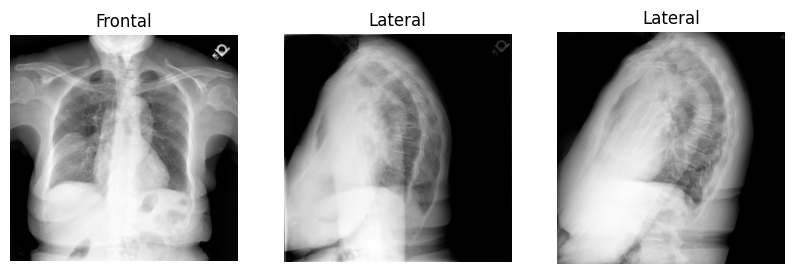

Real report: The heart is normal in size. Atherosclerotic calcifications of the aorta. The mediastinum is stable. There is again soft tissue density projected over the right mid chest, XXXX patient's known large breast mass. The appearance is grossly stable to decreased from prior study. The lateral projection is suboptimal as patient could not raise XXXX. There is no pleural effusion.

Generated report: . Heart size is normal. Lungs are clear. No pneumonia, effusions, edema, pneumothorax, adenopathy, nodules or masses.


In [66]:
id = 3324
pred = compare_report(id)
real = get_findings_for_uid(id)
print(f'Real report: {real}\n\nGenerated report: {pred}')

In [176]:
from nltk.translate.bleu_score import sentence_bleu

In [270]:
for i in range(1, 5):
    weights = [1/i]*i + [0]*(4-i)  # weights for 1-gram to 4-gram
    bleu_score = sentence_bleu([real.split()], pred.split(), weights=weights)
    print(f"BLEU-{i} score:", bleu_score)

# METEOR
meteor_scr = meteor_score([real.split()], pred.split())
print("METEOR score:", meteor_scr)

# ROUGE
scores = scorer.score(pred, real)
print("ROUGE-1: ", scores['rouge1'])
print("ROUGE-2: ", scores['rouge2'])
print("ROUGE-L: ", scores['rougeL'])

# BERTScore
P, R, F1 = bert_score([pred], [real], lang="en")
print("BERTScore: ", F1.item())

BLEU-1 score: 0.25
BLEU-2 score: 0.14744195615489714
BLEU-3 score: 0.09960317042892665
BLEU-4 score: 2.165414196653705e-78
METEOR score: 0.34074074074074073
ROUGE-1:  Score(precision=0.5, recall=0.2916666666666667, fmeasure=0.3684210526315789)
ROUGE-2:  Score(precision=0.23076923076923078, recall=0.13043478260869565, fmeasure=0.16666666666666669)
ROUGE-L:  Score(precision=0.5, recall=0.2916666666666667, fmeasure=0.3684210526315789)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERTScore:  0.8831519484519958


In [235]:
# Initialize the metrics
bleu1_scores = []
bleu2_scores = []
bleu3_scores = []
bleu4_scores = []
rouge1_scores = []
rouge2_scores = []
rougeL_scores = []
meteor_scores = []
bert_scores = []

In [236]:
from nltk.translate.bleu_score import sentence_bleu


# Iterate over all test_uids
for uid in tqdm.tqdm(test_uids):
    # Get predicted findings using compare_report function
    predicted_findings = compare_report(uid)
    
    # Get actual findings using get_findings_for_uid function
    actual_findings = get_findings_for_uid(uid)
    
    # Check if both predicted and actual findings are not None
    if predicted_findings is not np.nan and actual_findings is not np.nan:
        # Increment total predictions count
#         bleu_score = sentence_bleu([actual_findings.split()], predicted_findings.split(), weights=weights, smoothing_function=smoothie)
        bleu1_scores.append(sentence_bleu([actual_findings.split()], predicted_findings.split(), weights=(1, 0, 0, 0), smoothing_function=smoothie))
        bleu2_scores.append(sentence_bleu([actual_findings.split()], predicted_findings.split(), weights=(0.5, 0.5, 0, 0), smoothing_function=smoothie))
        bleu3_scores.append(sentence_bleu([actual_findings.split()], predicted_findings.split(), weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothie))
        bleu4_scores.append(sentence_bleu([actual_findings.split()], predicted_findings.split(), weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie))
        
        # METEOR
        meteor_scr = meteor_score([actual_findings.split()], predicted_findings.split())
        meteor_scores.append(meteor_scr)
        print("METEOR score:", meteor_scr)

        # ROUGE
        scores = scorer.score(predicted_findings, actual_findings)
        rouge1_scores.append(scores['rouge1'])
        rouge2_scores.append(scores['rouge2'])
        rougeL_scores.append(scores['rougeL'])
#         print("ROUGE-1: ", scores['rouge1'])
#         print("ROUGE-2: ", scores['rouge2'])
#         print("ROUGE-L: ", scores['rougeL'])

        # BERTScore
        P, R, F1 = bert_score([predicted_findings], [actual_findings], lang="en")
#         print("BERTScore: ", F1.item())
        bert_scores.append(F1.item())

  0%|          | 0/386 [00:00<?, ?it/s]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 1/386 [00:01<08:27,  1.32s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  1%|          | 2/386 [00:02<08:50,  1.38s/it]

METEOR score: 0.1780874951606659


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  1%|          | 4/386 [00:06<09:31,  1.50s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  1%|▏         | 5/386 [00:07<09:17,  1.46s/it]

METEOR score: 0.24302551903114183


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  2%|▏         | 7/386 [00:09<07:08,  1.13s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  2%|▏         | 8/386 [00:11<07:26,  1.18s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  2%|▏         | 9/386 [00:12<07:52,  1.25s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  3%|▎         | 10/386 [00:14<09:02,  1.44s/it]

METEOR score: 0.22203445524104587


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  3%|▎         | 11/386 [00:16<09:32,  1.53s/it]

METEOR score: 0.4191538275389207


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  3%|▎         | 12/386 [00:18<10:19,  1.66s/it]

METEOR score: 0.25039508795564647


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  3%|▎         | 13/386 [00:19<10:39,  1.71s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  4%|▍         | 15/386 [00:21<07:58,  1.29s/it]

METEOR score: 0.16589506172839508


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  4%|▍         | 16/386 [00:23<08:42,  1.41s/it]

METEOR score: 0.28758542141230065


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  4%|▍         | 17/386 [00:25<09:20,  1.52s/it]

METEOR score: 0.12354570637119112


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  5%|▍         | 18/386 [00:26<09:24,  1.53s/it]

METEOR score: 0.23544303797468352


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  5%|▍         | 19/386 [00:28<09:42,  1.59s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  5%|▌         | 20/386 [00:29<09:23,  1.54s/it]

METEOR score: 0.2573578042328042


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  5%|▌         | 21/386 [00:31<09:45,  1.60s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  6%|▌         | 22/386 [00:33<09:22,  1.54s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  6%|▌         | 23/386 [00:34<09:04,  1.50s/it]

METEOR score: 0.274242912371134


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  6%|▌         | 24/386 [00:36<09:54,  1.64s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  7%|▋         | 26/386 [00:38<07:36,  1.27s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  7%|▋         | 27/386 [00:39<07:44,  1.29s/it]

METEOR score: 0.1732668829888313


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  7%|▋         | 28/386 [00:41<08:27,  1.42s/it]

METEOR score: 0.29406055900621114


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  8%|▊         | 29/386 [00:43<08:57,  1.50s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  8%|▊         | 30/386 [00:44<08:45,  1.48s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  8%|▊         | 31/386 [00:46<08:52,  1.50s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  8%|▊         | 32/386 [00:47<08:40,  1.47s/it]

METEOR score: 0.3893290542573463


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  9%|▊         | 33/386 [00:49<09:16,  1.58s/it]

METEOR score: 0.1388888888888889


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 10%|▉         | 37/386 [00:52<04:48,  1.21it/s]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 10%|▉         | 38/386 [00:53<05:44,  1.01it/s]

METEOR score: 0.179372197309417


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 10%|█         | 40/386 [00:55<05:15,  1.10it/s]

METEOR score: 0.17503351705645764


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 11%|█         | 41/386 [00:57<06:51,  1.19s/it]

METEOR score: 0.31701776125567943


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 11%|█         | 42/386 [00:59<07:52,  1.37s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 11%|█         | 43/386 [01:00<07:55,  1.39s/it]

METEOR score: 0.12711864406779658


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 11%|█▏        | 44/386 [01:02<08:36,  1.51s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 12%|█▏        | 45/386 [01:03<08:23,  1.48s/it]

METEOR score: 0.09554140127388534


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 12%|█▏        | 46/386 [01:05<08:56,  1.58s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 12%|█▏        | 47/386 [01:07<08:38,  1.53s/it]

METEOR score: 0.17804444444444445


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 13%|█▎        | 49/386 [01:09<07:20,  1.31s/it]

METEOR score: 0.2581803469377434


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 13%|█▎        | 50/386 [01:11<07:49,  1.40s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 13%|█▎        | 51/386 [01:12<07:53,  1.41s/it]

METEOR score: 0.1838235294117647


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 13%|█▎        | 52/386 [01:14<08:10,  1.47s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 14%|█▎        | 53/386 [01:15<08:02,  1.45s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 14%|█▍        | 54/386 [01:17<08:26,  1.53s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 14%|█▍        | 55/386 [01:18<08:12,  1.49s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 15%|█▍        | 56/386 [01:20<08:00,  1.46s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 15%|█▍        | 57/386 [01:22<08:51,  1.62s/it]

METEOR score: 0.09652509652509651


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 15%|█▌        | 58/386 [01:24<09:49,  1.80s/it]

METEOR score: 0.18735362997658078


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 15%|█▌        | 59/386 [01:26<10:12,  1.87s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 16%|█▌        | 60/386 [01:27<09:30,  1.75s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 16%|█▌        | 61/386 [01:29<09:00,  1.66s/it]

METEOR score: 0.1342281879194631


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 16%|█▌        | 62/386 [01:31<08:57,  1.66s/it]

METEOR score: 0.21463730569948186


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 16%|█▋        | 63/386 [01:32<08:59,  1.67s/it]

METEOR score: 0.13964341443680287


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 17%|█▋        | 64/386 [01:34<09:12,  1.72s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 17%|█▋        | 66/386 [01:36<06:50,  1.28s/it]

METEOR score: 0.16357160148009828


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 17%|█▋        | 67/386 [01:38<07:30,  1.41s/it]

METEOR score: 0.26031597242564486


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 18%|█▊        | 68/386 [01:39<08:02,  1.52s/it]

METEOR score: 0.1286764705882353


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 18%|█▊        | 69/386 [01:41<08:17,  1.57s/it]

METEOR score: 0.4445422535211268


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 18%|█▊        | 70/386 [01:43<08:34,  1.63s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 18%|█▊        | 71/386 [01:44<08:09,  1.55s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 19%|█▊        | 72/386 [01:46<07:52,  1.50s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 19%|█▉        | 73/386 [01:47<07:49,  1.50s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 19%|█▉        | 74/386 [01:49<07:41,  1.48s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 19%|█▉        | 75/386 [01:50<07:34,  1.46s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 20%|█▉        | 76/386 [01:51<07:32,  1.46s/it]

METEOR score: 0.14423076923076922


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 20%|█▉        | 77/386 [01:53<07:40,  1.49s/it]

METEOR score: 0.026178010471204192


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 20%|██        | 78/386 [01:55<07:43,  1.51s/it]

METEOR score: 0.286281179138322


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 20%|██        | 79/386 [01:56<08:23,  1.64s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 21%|██        | 80/386 [01:58<08:00,  1.57s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 21%|██        | 81/386 [01:59<07:44,  1.52s/it]

METEOR score: 0.06539706884798908


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 21%|██        | 82/386 [02:02<08:53,  1.76s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 22%|██▏       | 83/386 [02:03<08:21,  1.66s/it]

METEOR score: 0.311435115356684


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 22%|██▏       | 84/386 [02:05<08:26,  1.68s/it]

METEOR score: 0.15975206611570247


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 22%|██▏       | 86/386 [02:07<06:44,  1.35s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 23%|██▎       | 87/386 [02:08<06:44,  1.35s/it]

METEOR score: 0.1271


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 23%|██▎       | 88/386 [02:10<07:32,  1.52s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 23%|██▎       | 89/386 [02:12<07:22,  1.49s/it]

METEOR score: 0.18588830881189686


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 23%|██▎       | 90/386 [02:13<07:43,  1.57s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 24%|██▎       | 91/386 [02:15<07:25,  1.51s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 24%|██▍       | 93/386 [02:17<05:56,  1.22s/it]

METEOR score: 0.3300796812749004


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 24%|██▍       | 94/386 [02:19<07:01,  1.44s/it]

METEOR score: 0.06249999999999999


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 25%|██▍       | 95/386 [02:21<07:23,  1.52s/it]

METEOR score: 0.07092198581560283


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 25%|██▍       | 96/386 [02:23<08:12,  1.70s/it]

METEOR score: 0.22667754990987315


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 25%|██▌       | 97/386 [02:24<08:11,  1.70s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 25%|██▌       | 98/386 [02:26<07:44,  1.61s/it]

METEOR score: 0.20672061928219565


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 26%|██▌       | 99/386 [02:28<07:58,  1.67s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 26%|██▌       | 101/386 [02:29<05:40,  1.19s/it]

METEOR score: 0.14792899408284024


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 26%|██▋       | 102/386 [02:31<07:00,  1.48s/it]

METEOR score: 0.4745565878378378


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 27%|██▋       | 103/386 [02:33<07:28,  1.58s/it]

METEOR score: 0.1558641975308642


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 27%|██▋       | 106/386 [02:35<04:04,  1.14it/s]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 28%|██▊       | 107/386 [02:37<04:46,  1.03s/it]

METEOR score: 0.22409638554216865


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 28%|██▊       | 108/386 [02:38<05:39,  1.22s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 28%|██▊       | 109/386 [02:40<05:54,  1.28s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 28%|██▊       | 110/386 [02:41<06:08,  1.33s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 29%|██▉       | 111/386 [02:43<06:11,  1.35s/it]

METEOR score: 0.1972806139472806


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 29%|██▉       | 112/386 [02:44<06:50,  1.50s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 29%|██▉       | 113/386 [02:46<06:46,  1.49s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 30%|██▉       | 115/386 [02:48<05:25,  1.20s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 30%|███       | 116/386 [02:49<05:33,  1.23s/it]

METEOR score: 0.249505928853755


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 30%|███       | 117/386 [02:51<06:24,  1.43s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 31%|███       | 118/386 [02:53<06:22,  1.43s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 31%|███       | 119/386 [02:54<06:43,  1.51s/it]

METEOR score: 0.08695652173913043


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 31%|███       | 120/386 [02:56<07:03,  1.59s/it]

METEOR score: 0.25230111768573305


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 31%|███▏      | 121/386 [02:58<07:17,  1.65s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 32%|███▏      | 122/386 [02:59<06:55,  1.57s/it]

METEOR score: 0.052816901408450696


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 32%|███▏      | 123/386 [03:01<07:08,  1.63s/it]

METEOR score: 0.10638297872340426


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 32%|███▏      | 124/386 [03:03<07:11,  1.65s/it]

METEOR score: 0.04975124378109454


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 33%|███▎      | 126/386 [03:05<05:45,  1.33s/it]

METEOR score: 0.3633771929824562


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 33%|███▎      | 127/386 [03:07<06:44,  1.56s/it]

METEOR score: 0.1851851851851852


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 33%|███▎      | 128/386 [03:09<07:08,  1.66s/it]

METEOR score: 0.34074074074074073


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 33%|███▎      | 129/386 [03:11<07:11,  1.68s/it]

METEOR score: 0.22477341389728095


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 34%|███▎      | 130/386 [03:12<07:05,  1.66s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 34%|███▍      | 131/386 [03:14<06:42,  1.58s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 34%|███▍      | 132/386 [03:15<06:28,  1.53s/it]

METEOR score: 0.41713430602319496


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 34%|███▍      | 133/386 [03:17<07:11,  1.71s/it]

METEOR score: 0.16062340966921118


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 35%|███▍      | 134/386 [03:19<07:00,  1.67s/it]

METEOR score: 0.3392371661602431


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 35%|███▍      | 135/386 [03:21<07:04,  1.69s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 35%|███▌      | 137/386 [03:22<04:57,  1.19s/it]

METEOR score: 0.18445839874411302


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 36%|███▌      | 138/386 [03:24<05:27,  1.32s/it]

METEOR score: 0.23834745762711862


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 36%|███▌      | 139/386 [03:25<05:47,  1.41s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 36%|███▋      | 140/386 [03:27<05:39,  1.38s/it]

METEOR score: 0.2391304347826087


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 37%|███▋      | 141/386 [03:28<06:05,  1.49s/it]

METEOR score: 0.6159076380683028


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 37%|███▋      | 142/386 [03:30<06:21,  1.56s/it]

METEOR score: 0.25357470812016264


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 37%|███▋      | 143/386 [03:32<06:43,  1.66s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 38%|███▊      | 145/386 [03:34<05:07,  1.28s/it]

METEOR score: 0.4323630136986302


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 38%|███▊      | 146/386 [03:36<05:46,  1.44s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 38%|███▊      | 147/386 [03:37<05:36,  1.41s/it]

METEOR score: 0.1116201279813845


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 39%|███▊      | 149/386 [03:40<05:12,  1.32s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 39%|███▉      | 150/386 [03:41<05:11,  1.32s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 39%|███▉      | 151/386 [03:43<05:15,  1.34s/it]

METEOR score: 0.1354873822004526


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 39%|███▉      | 152/386 [03:44<05:32,  1.42s/it]

METEOR score: 0.3640776699029127


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 40%|███▉      | 153/386 [03:46<05:50,  1.51s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 40%|███▉      | 154/386 [03:47<05:40,  1.47s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 40%|████      | 155/386 [03:49<05:33,  1.44s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 40%|████      | 156/386 [03:50<05:28,  1.43s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 41%|████      | 157/386 [03:51<05:24,  1.42s/it]

METEOR score: 0.15350877192982454


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 41%|████      | 158/386 [03:54<06:41,  1.76s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 41%|████      | 159/386 [03:55<06:15,  1.66s/it]

METEOR score: 0.3377258546730794


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 41%|████▏     | 160/386 [03:57<06:29,  1.72s/it]

METEOR score: 0.9998177842565598


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 42%|████▏     | 161/386 [03:59<06:21,  1.69s/it]

METEOR score: 0.1933838051349573


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 42%|████▏     | 162/386 [04:01<06:21,  1.70s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 42%|████▏     | 163/386 [04:02<06:05,  1.64s/it]

METEOR score: 0.36756594122956576


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 42%|████▏     | 164/386 [04:04<06:14,  1.69s/it]

METEOR score: 0.12195121951219512


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 43%|████▎     | 165/386 [04:06<06:16,  1.70s/it]

METEOR score: 0.30273437499999994


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 43%|████▎     | 166/386 [04:07<06:20,  1.73s/it]

METEOR score: 0.209163547075635


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 43%|████▎     | 167/386 [04:09<06:22,  1.75s/it]

METEOR score: 0.28237674760853565


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 44%|████▎     | 168/386 [04:11<06:28,  1.78s/it]

METEOR score: 0.4489795918367347


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 44%|████▍     | 169/386 [04:13<06:54,  1.91s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 44%|████▍     | 170/386 [04:15<06:23,  1.77s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 44%|████▍     | 171/386 [04:16<05:55,  1.66s/it]

METEOR score: 0.19794936179116973


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 45%|████▍     | 172/386 [04:18<06:01,  1.69s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 45%|████▍     | 173/386 [04:19<05:41,  1.60s/it]

METEOR score: 0.2786855482933915


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 45%|████▌     | 174/386 [04:21<05:59,  1.70s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 46%|████▌     | 176/386 [04:23<04:34,  1.31s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 46%|████▌     | 177/386 [04:25<04:38,  1.33s/it]

METEOR score: 0.23834719072814314


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 46%|████▌     | 178/386 [04:26<04:59,  1.44s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 46%|████▋     | 179/386 [04:28<04:54,  1.42s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 47%|████▋     | 180/386 [04:29<04:52,  1.42s/it]

METEOR score: 0.28084745762711866


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 47%|████▋     | 181/386 [04:31<05:05,  1.49s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 47%|████▋     | 182/386 [04:32<04:58,  1.46s/it]

METEOR score: 0.1535024154589372


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 48%|████▊     | 184/386 [04:35<04:39,  1.38s/it]

METEOR score: 0.013123359580052492


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 48%|████▊     | 185/386 [04:36<04:45,  1.42s/it]

METEOR score: 0.07211538461538461


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 48%|████▊     | 186/386 [04:38<04:51,  1.46s/it]

METEOR score: 0.2608695652173913


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 49%|████▉     | 190/386 [04:41<02:49,  1.15it/s]

METEOR score: 0.3475324675324675


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 49%|████▉     | 191/386 [04:43<03:44,  1.15s/it]

METEOR score: 0.2590266875981162


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 50%|█████     | 193/386 [04:46<03:47,  1.18s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 50%|█████     | 194/386 [04:47<03:57,  1.24s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 51%|█████     | 195/386 [04:49<04:08,  1.30s/it]

METEOR score: 0.13761467889908252


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 51%|█████     | 197/386 [04:50<03:21,  1.07s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 51%|█████▏    | 198/386 [04:52<03:54,  1.25s/it]

METEOR score: 0.37656416723251523


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 52%|█████▏    | 200/386 [04:55<03:42,  1.20s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 52%|█████▏    | 201/386 [04:56<03:52,  1.26s/it]

METEOR score: 0.058823529411764705


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 52%|█████▏    | 202/386 [04:58<04:21,  1.42s/it]

METEOR score: 0.2871305649083427


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 53%|█████▎    | 203/386 [05:00<04:46,  1.57s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 53%|█████▎    | 204/386 [05:01<04:37,  1.52s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 53%|█████▎    | 205/386 [05:03<04:29,  1.49s/it]

METEOR score: 0.19989067055393583


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 53%|█████▎    | 206/386 [05:05<05:04,  1.69s/it]

METEOR score: 0.21534792368125702


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 54%|█████▎    | 207/386 [05:07<05:11,  1.74s/it]

METEOR score: 0.07425742574257424


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 54%|█████▍    | 208/386 [05:08<05:09,  1.74s/it]

METEOR score: 0.14711406034806562


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 54%|█████▍    | 209/386 [05:11<05:43,  1.94s/it]

METEOR score: 0.3443567961165048


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 54%|█████▍    | 210/386 [05:13<05:54,  2.02s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 55%|█████▍    | 211/386 [05:14<05:20,  1.83s/it]

METEOR score: 0.15726495726495726


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 55%|█████▍    | 212/386 [05:16<05:05,  1.75s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 55%|█████▌    | 213/386 [05:17<04:44,  1.64s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 56%|█████▌    | 215/386 [05:19<03:21,  1.18s/it]

METEOR score: 0.1435406698564593


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 56%|█████▌    | 216/386 [05:21<03:38,  1.29s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 56%|█████▌    | 217/386 [05:22<03:43,  1.32s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 56%|█████▋    | 218/386 [05:23<03:45,  1.34s/it]

METEOR score: 0.11210762331838564


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 57%|█████▋    | 219/386 [05:25<04:07,  1.48s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 57%|█████▋    | 220/386 [05:27<04:03,  1.47s/it]

METEOR score: 0.1762114537444934


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 57%|█████▋    | 221/386 [05:29<04:49,  1.76s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 58%|█████▊    | 222/386 [05:30<04:31,  1.66s/it]

METEOR score: 0.21095710634770795


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 58%|█████▊    | 224/386 [05:33<03:27,  1.28s/it]

METEOR score: 0.3378002088409328


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 58%|█████▊    | 225/386 [05:34<03:49,  1.42s/it]

METEOR score: 0.46875


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 59%|█████▊    | 226/386 [05:36<04:05,  1.53s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 59%|█████▉    | 228/386 [05:38<03:17,  1.25s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 59%|█████▉    | 229/386 [05:40<03:21,  1.29s/it]

METEOR score: 0.19315481365559614


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 60%|█████▉    | 230/386 [05:41<03:42,  1.43s/it]

METEOR score: 0.1704458350173512


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 60%|█████▉    | 231/386 [05:43<03:49,  1.48s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 60%|██████    | 232/386 [05:44<03:50,  1.50s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 60%|██████    | 233/386 [05:46<04:04,  1.60s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 61%|██████    | 234/386 [05:48<03:56,  1.56s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 61%|██████    | 236/386 [05:49<02:46,  1.11s/it]

METEOR score: 0.6479126933672389


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 61%|██████▏   | 237/386 [05:51<03:21,  1.35s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 62%|██████▏   | 238/386 [05:53<03:21,  1.36s/it]

METEOR score: 0.19103664192949907


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 62%|██████▏   | 239/386 [05:54<03:28,  1.42s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 62%|██████▏   | 240/386 [05:56<03:26,  1.41s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 62%|██████▏   | 241/386 [05:57<03:35,  1.48s/it]

METEOR score: 0.05422993492407809


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 63%|██████▎   | 242/386 [05:59<03:37,  1.51s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 63%|██████▎   | 243/386 [06:00<03:35,  1.51s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 63%|██████▎   | 244/386 [06:02<03:32,  1.49s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 63%|██████▎   | 245/386 [06:03<03:27,  1.47s/it]

METEOR score: 0.20047318611987383


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 64%|██████▎   | 246/386 [06:05<03:33,  1.53s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 64%|██████▍   | 247/386 [06:06<03:26,  1.48s/it]

METEOR score: 0.08379888268156424


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 64%|██████▍   | 248/386 [06:08<03:32,  1.54s/it]

METEOR score: 0.14936614466815812


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 65%|██████▍   | 249/386 [06:10<03:40,  1.61s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 65%|██████▍   | 250/386 [06:11<03:28,  1.53s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 65%|██████▌   | 251/386 [06:13<03:24,  1.51s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 65%|██████▌   | 252/386 [06:14<03:15,  1.46s/it]

METEOR score: 0.37152466367713


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 66%|██████▌   | 253/386 [06:16<03:26,  1.55s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 66%|██████▌   | 254/386 [06:17<03:18,  1.51s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 67%|██████▋   | 257/386 [06:20<02:09,  1.00s/it]

METEOR score: 0.05102040816326531


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 67%|██████▋   | 258/386 [06:21<02:32,  1.19s/it]

METEOR score: 0.15769230769230766


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 67%|██████▋   | 259/386 [06:23<02:51,  1.35s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 67%|██████▋   | 260/386 [06:24<02:52,  1.37s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 68%|██████▊   | 261/386 [06:26<02:51,  1.37s/it]

METEOR score: 0.13353115727002965


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 68%|██████▊   | 262/386 [06:27<03:04,  1.49s/it]

METEOR score: 0.16


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 68%|██████▊   | 263/386 [06:29<03:13,  1.57s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 68%|██████▊   | 264/386 [06:31<03:05,  1.52s/it]

METEOR score: 0.08379888268156424


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 69%|██████▊   | 265/386 [06:32<03:10,  1.57s/it]

METEOR score: 0.2773277950848045


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 69%|██████▉   | 266/386 [06:34<03:30,  1.75s/it]

METEOR score: 0.4015928362704147


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 69%|██████▉   | 267/386 [06:36<03:29,  1.76s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 69%|██████▉   | 268/386 [06:38<03:14,  1.65s/it]

METEOR score: 0.2768640350877193


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 70%|██████▉   | 269/386 [06:39<03:16,  1.68s/it]

METEOR score: 0.11986301369863016


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 70%|███████   | 271/386 [06:42<02:32,  1.33s/it]

METEOR score: 0.21754535147392287


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 70%|███████   | 272/386 [06:44<02:52,  1.51s/it]

METEOR score: 0.15868223295759531


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 71%|███████   | 273/386 [06:46<03:05,  1.64s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 71%|███████   | 274/386 [06:47<02:55,  1.57s/it]

METEOR score: 0.106951871657754


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 71%|███████   | 275/386 [06:49<03:00,  1.62s/it]

METEOR score: 0.12531328320802004


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 72%|███████▏  | 276/386 [06:51<03:27,  1.88s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 72%|███████▏  | 277/386 [06:53<03:08,  1.73s/it]

METEOR score: 0.07443985849056603


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 72%|███████▏  | 278/386 [06:54<03:02,  1.69s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 73%|███████▎  | 280/386 [06:56<02:04,  1.18s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 73%|███████▎  | 281/386 [06:57<02:10,  1.24s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 73%|███████▎  | 282/386 [06:59<02:13,  1.29s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 73%|███████▎  | 283/386 [07:00<02:15,  1.32s/it]

METEOR score: 0.29719868173258


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 74%|███████▎  | 284/386 [07:02<02:30,  1.48s/it]

METEOR score: 0.17259461629096368


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 74%|███████▍  | 285/386 [07:04<02:39,  1.58s/it]

METEOR score: 0.14943484042553193


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 74%|███████▍  | 286/386 [07:05<02:37,  1.57s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 74%|███████▍  | 287/386 [07:07<02:31,  1.53s/it]

METEOR score: 0.07510729613733906


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 75%|███████▍  | 288/386 [07:08<02:32,  1.56s/it]

METEOR score: 0.1303998161764706


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 75%|███████▍  | 289/386 [07:10<02:36,  1.61s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 75%|███████▌  | 290/386 [07:11<02:27,  1.54s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 75%|███████▌  | 291/386 [07:13<02:21,  1.49s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 76%|███████▌  | 292/386 [07:14<02:15,  1.44s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 76%|███████▌  | 293/386 [07:15<02:11,  1.41s/it]

METEOR score: 0.14969818913480887


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 76%|███████▌  | 294/386 [07:17<02:17,  1.49s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 77%|███████▋  | 297/386 [07:19<01:12,  1.24it/s]

METEOR score: 0.20489495343296515


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 77%|███████▋  | 298/386 [07:21<01:34,  1.08s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 77%|███████▋  | 299/386 [07:22<01:42,  1.18s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 78%|███████▊  | 300/386 [07:23<01:46,  1.23s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 78%|███████▊  | 302/386 [07:25<01:26,  1.02s/it]

METEOR score: 0.12569832402234637


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 78%|███████▊  | 303/386 [07:27<01:41,  1.22s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 79%|███████▉  | 304/386 [07:28<01:44,  1.27s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 79%|███████▉  | 305/386 [07:30<01:45,  1.30s/it]

METEOR score: 0.2131805157593123


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 79%|███████▉  | 306/386 [07:31<01:57,  1.47s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 80%|███████▉  | 307/386 [07:33<01:52,  1.43s/it]

METEOR score: 0.23280571508614653


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 80%|███████▉  | 308/386 [07:35<01:59,  1.53s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 80%|████████  | 309/386 [07:36<02:01,  1.58s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 81%|████████  | 311/386 [07:38<01:28,  1.18s/it]

METEOR score: 0.11450381679389313


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 81%|████████  | 312/386 [07:40<01:37,  1.32s/it]

METEOR score: 0.3534069236548576


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 81%|████████  | 313/386 [07:41<01:44,  1.43s/it]

METEOR score: 0.136518771331058


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 81%|████████▏ | 314/386 [07:43<01:48,  1.51s/it]

METEOR score: 0.4210567210567211


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 82%|████████▏ | 316/386 [07:45<01:30,  1.29s/it]

METEOR score: 0.10752688172043011


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 82%|████████▏ | 317/386 [07:47<01:36,  1.40s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 82%|████████▏ | 318/386 [07:49<01:56,  1.72s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 83%|████████▎ | 319/386 [07:51<01:47,  1.61s/it]

METEOR score: 0.04716981132075472


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 83%|████████▎ | 320/386 [07:53<01:55,  1.76s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 83%|████████▎ | 321/386 [07:54<01:45,  1.62s/it]

METEOR score: 0.30828025477707005


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 83%|████████▎ | 322/386 [07:56<01:47,  1.69s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 84%|████████▍ | 324/386 [07:58<01:13,  1.19s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 84%|████████▍ | 325/386 [07:59<01:15,  1.23s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 85%|████████▍ | 327/386 [08:01<00:58,  1.01it/s]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 85%|████████▍ | 328/386 [08:02<01:04,  1.11s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 85%|████████▌ | 329/386 [08:04<01:08,  1.20s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 85%|████████▌ | 330/386 [08:05<01:10,  1.26s/it]

METEOR score: 0.17877940833915676


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 86%|████████▌ | 331/386 [08:07<01:16,  1.40s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 86%|████████▌ | 332/386 [08:08<01:16,  1.41s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 87%|████████▋ | 334/386 [08:10<00:59,  1.14s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 87%|████████▋ | 335/386 [08:11<01:02,  1.22s/it]

METEOR score: 0.315218573292736


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 87%|████████▋ | 336/386 [08:13<01:10,  1.41s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 87%|████████▋ | 337/386 [08:15<01:08,  1.40s/it]

METEOR score: 0.021834061135371178


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 88%|████████▊ | 339/386 [08:17<00:55,  1.18s/it]

METEOR score: 0.18404907975460122


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 88%|████████▊ | 340/386 [08:19<01:03,  1.38s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 88%|████████▊ | 341/386 [08:20<01:02,  1.39s/it]

METEOR score: 0.1383399209486166


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 89%|████████▊ | 342/386 [08:22<01:07,  1.54s/it]

METEOR score: 0.09510869565217392


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 89%|████████▉ | 343/386 [08:24<01:08,  1.59s/it]

METEOR score: 0.19172297297297297


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 89%|████████▉ | 344/386 [08:25<01:09,  1.65s/it]

METEOR score: 0.22788808664259927


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 89%|████████▉ | 345/386 [08:28<01:16,  1.86s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 90%|████████▉ | 346/386 [08:29<01:08,  1.71s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 90%|████████▉ | 347/386 [08:31<01:08,  1.75s/it]

METEOR score: 0.15228426395939085


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 90%|█████████ | 348/386 [08:33<01:10,  1.86s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 90%|█████████ | 349/386 [08:34<01:03,  1.71s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 91%|█████████ | 350/386 [08:36<00:58,  1.61s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 91%|█████████ | 351/386 [08:37<00:53,  1.54s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 91%|█████████▏| 353/386 [08:39<00:40,  1.22s/it]

METEOR score: 0.23031655844155843


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 92%|█████████▏| 354/386 [08:41<00:43,  1.36s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 92%|█████████▏| 355/386 [08:42<00:42,  1.38s/it]

METEOR score: 0.2475797140065725


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 92%|█████████▏| 357/386 [08:44<00:32,  1.14s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 93%|█████████▎| 359/386 [08:46<00:25,  1.06it/s]

METEOR score: 0.1372549019607843


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 93%|█████████▎| 360/386 [08:48<00:29,  1.14s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 94%|█████████▎| 361/386 [08:49<00:30,  1.21s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 94%|█████████▍| 364/386 [08:51<00:19,  1.15it/s]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 95%|█████████▍| 366/386 [08:53<00:18,  1.10it/s]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 95%|█████████▌| 367/386 [08:55<00:19,  1.05s/it]

METEOR score: 0.16304347826086957


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 95%|█████████▌| 368/386 [08:56<00:22,  1.26s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 96%|█████████▌| 369/386 [08:58<00:22,  1.30s/it]

METEOR score: 0.11904761904761905


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 96%|█████████▌| 370/386 [09:00<00:23,  1.44s/it]

METEOR score: 0.176056338028169


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 96%|█████████▌| 371/386 [09:02<00:24,  1.66s/it]

METEOR score: 0.12261580381471388


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 96%|█████████▋| 372/386 [09:04<00:24,  1.74s/it]

METEOR score: 0.11232206405693951


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 97%|█████████▋| 373/386 [09:05<00:21,  1.68s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 97%|█████████▋| 374/386 [09:07<00:19,  1.59s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 97%|█████████▋| 376/386 [09:08<00:11,  1.13s/it]

METEOR score: 0.07592592592592592


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 98%|█████████▊| 377/386 [09:10<00:11,  1.31s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 98%|█████████▊| 378/386 [09:11<00:10,  1.33s/it]

METEOR score: 0.35331156716417905


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 98%|█████████▊| 379/386 [09:13<00:10,  1.46s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 98%|█████████▊| 380/386 [09:15<00:08,  1.45s/it]

METEOR score: 0.18883248730964466


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 99%|█████████▊| 381/386 [09:16<00:07,  1.55s/it]

METEOR score: 0.13972055888223556


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 99%|█████████▉| 382/386 [09:18<00:06,  1.59s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 99%|█████████▉| 383/386 [09:19<00:04,  1.54s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 99%|█████████▉| 384/386 [09:21<00:03,  1.51s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|█████████▉| 385/386 [09:22<00:01,  1.49s/it]

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 386/386 [09:24<00:00,  1.46s/it]


In [237]:
meteor_scores

[0.0,
 0.0,
 0.1780874951606659,
 0.0,
 0.24302551903114183,
 0.0,
 0.0,
 0.0,
 0.22203445524104587,
 0.4191538275389207,
 0.25039508795564647,
 0.0,
 0.16589506172839508,
 0.28758542141230065,
 0.12354570637119112,
 0.23544303797468352,
 0.0,
 0.2573578042328042,
 0.0,
 0.0,
 0.274242912371134,
 0.0,
 0.0,
 0.1732668829888313,
 0.29406055900621114,
 0.0,
 0.0,
 0.0,
 0.3893290542573463,
 0.1388888888888889,
 0.0,
 0.179372197309417,
 0.17503351705645764,
 0.31701776125567943,
 0.0,
 0.12711864406779658,
 0.0,
 0.09554140127388534,
 0.0,
 0.17804444444444445,
 0.2581803469377434,
 0.0,
 0.1838235294117647,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.09652509652509651,
 0.18735362997658078,
 0.0,
 0.0,
 0.1342281879194631,
 0.21463730569948186,
 0.13964341443680287,
 0.0,
 0.16357160148009828,
 0.26031597242564486,
 0.1286764705882353,
 0.4445422535211268,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.14423076923076922,
 0.026178010471204192,
 0.286281179138322,
 0.0,
 0.0,
 0.06539706884798908,
 0.0,
 0

In [262]:
arr_to_avg = bert_scores
arr_non_zero = np.array(arr_to_avg)[np.array(arr_to_avg) != 0.0]
arr_non_zero.mean()

0.882098650591714

In [264]:
cc = np.trim_zeros(np.array(arr_to_avg))
cc.mean()

0.47063190199253035

In [103]:
len(bleu1_scores), len(bleu2_scores), len(bleu3_scores), len(bleu4_scores)

(334, 334, 334, 334)

___

In [ ]:
# def compare_report(uid):
#     print("Patient UID:", uid)
#     uid_projection_df = projections_df[projections_df.uid==uid]
#     print(uid_projection_df)
#     image_paths = [os.path.join(img_base_dir, img_path) for img_path in uid_projection_df.filename]
#     findings = reports_df[reports_df.uid==uid].findings.iloc[0]
    
#     plt.figure(figsize=(10, 5))
#     for i, (img, proj) in enumerate(zip(image_paths, list(uid_projection_df.projection))):
#         if len(image_paths) > 1:
#             plt.subplot(1, len(image_paths), i+1)
#         png_img = Image.open(img)
#         png_img = png_img.convert('RGB')
#         plt.title(proj)
#         plt.imshow(png_img)
#         plt.axis('off')
#     plt.show()
#     print("Findings:", findings)
#     generated_report = generate_report(image_paths)
#     print("Generated Report:", generated_report)

#     # Инициализация скореров
#     scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
#     smoothie = SmoothingFunction().method4

#     # BLEU
#     for i in range(1, 5):
#         weights = [1/i]*i + [0]*(4-i)  # weights for 1-gram to 4-gram
#         bleu_score = sentence_bleu([findings.split()], generated_report.split(), weights=weights, smoothing_function=smoothie)
#         print(f"BLEU-{i} score:", bleu_score)
    
#     # METEOR
#     meteor_scr = meteor_score([findings.split()], generated_report.split())
#     print("METEOR score:", meteor_scr)
    
#     # ROUGE
#     scores = scorer.score(findings, generated_report)
#     print("ROUGE-1: ", scores['rouge1'])
#     print("ROUGE-2: ", scores['rouge2'])
#     print("ROUGE-L: ", scores['rougeL'])

#     # BERTScore
#     P, R, F1 = bert_score([generated_report], [findings], lang="en")
#     print("BERTScore: ", F1.item())

Patient UID: 962


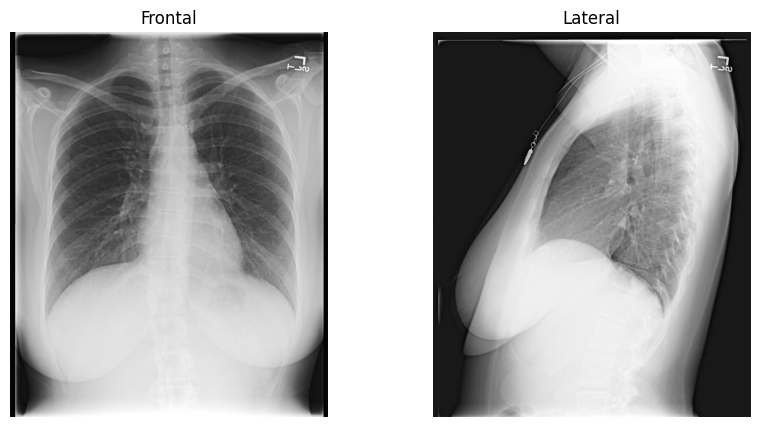

Findings: The lungs are clear. There is no pleural effusion or pneumothorax. The heart and mediastinum are normal. The skeletal structures are normal.
Generated Report: 


In [65]:
compare_report(np.random.choice(test_uids))

In [ ]:
reports_df[reports_df['uid']==1898]

In [ ]:
compare_report(3607)
# /content/images/images_normalized/3281_IM-1562-3001.dcm.png
# /content/images/images_normalized/2677_IM-1151-1001.dcm.png bullet
# /content/images/images_normalized/2910_IM-1314-1001.dcm.png
# /content/images/images_normalized/3607_IM-1781-1001.dcm.png

Get average score for 50 random samples

In [ ]:
def compare_report_avg(uid):
    uid_projection_df = projections_df[projections_df.uid==uid]
    image_paths = [os.path.join(img_base_dir, img_path) for img_path in uid_projection_df.filename]
    findings = reports_df[reports_df.uid==uid].findings.iloc[0]
    
    generated_report = generate_report(image_paths)
    
    # Initialize scorers
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    smoothie = SmoothingFunction().method4

    # BLEU
    bleu_scores = []
    for i in range(1, 5):
        weights = [1/i]*i + [0]*(4-i)  # weights for 1-gram to 4-gram
        bleu_score = sentence_bleu([findings.split()], generated_report.split(), weights=weights, smoothing_function=smoothie)
        bleu_scores.append(bleu_score)
#     bleu_scores.append(bleu_scores_temp)
    
    # METEOR
    meteor_scr = meteor_score([findings.split()], generated_report.split())
    
    # ROUGE
    scores = scorer.score(findings, generated_report)
    rouge1 = scores['rouge1'].fmeasure
    rouge2 = scores['rouge2'].fmeasure
    rougeL = scores['rougeL'].fmeasure

    # BERTScore
    P, R, F1 = bert_score([generated_report], [findings], lang="en")
    bertscore = F1.item()
    
    return bleu_scores, rouge1, rouge2, rougeL, meteor_scr, bertscore

In [ ]:
# Initialize the metrics
bleu1_scores = []
bleu2_scores = []
bleu3_scores = []
bleu4_scores = []
rouge1_scores = []
rouge2_scores = []
rougeL_scores = []
meteor_scores = []
bert_scores = []

In [ ]:
# Run the loop and call the function 50 times
for i in range(50):
    try:
        bleu_scores, rouge1, rouge2, rougeL, meteor_scr, bertscore = compare_report_avg(np.random.choice(test_uids))
        bleu1_scores.append(bleu_scores[0])
        bleu2_scores.append(bleu_scores[1])
        bleu3_scores.append(bleu_scores[2])
        bleu4_scores.append(bleu_scores[3])
        rouge1_scores.append(rouge1)
        rouge2_scores.append(rouge2)
        rougeL_scores.append(rougeL)
        meteor_scores.append(meteor_scr)
        bert_scores.append(bertscore)
    except AttributeError as e:
        print(f"Произошла ошибка AttributeError: {e}")
        continue

In [ ]:
bleu1_scores = [x for x in bleu1_scores if x != 0 and x != 0.0]
bleu2_scores = [x for x in bleu2_scores if x != 0 and x != 0.0]
bleu3_scores = [x for x in bleu3_scores if x != 0 and x != 0.0]
bleu4_scores = [x for x in bleu4_scores if x != 0 and x != 0.0]
rouge1_scores = [x for x in rouge1_scores if x != 0 and x != 0.0]
rouge2_scores = [x for x in rouge2_scores if x != 0 and x != 0.0]
rougeL_scores = [x for x in rougeL_scores if x != 0 and x != 0.0]
meteor_scores = [x for x in meteor_scores if x != 0 and x != 0.0]
bert_scores = [x for x in bert_scores if x != 0 and x != 0.0]

In [ ]:
# Calculate the average values of the metrics
avg_bleu1 = np.mean(bleu1_scores)
avg_bleu2 = np.mean(bleu2_scores)
avg_bleu3 = np.mean(bleu3_scores)
avg_bleu4 = np.mean(bleu4_scores)
avg_rouge1 = np.mean(rouge1_scores)
avg_rouge2 = np.mean(rouge2_scores)
avg_rougeL = np.mean(rougeL_scores)
avg_meteor = np.mean(meteor_scores)
avg_bert = np.mean(bert_scores)

In [ ]:
print("Average BLEU-1 score:", avg_bleu1)
print("Average BLEU-2 score:", avg_bleu2)
print("Average BLEU-3 score:", avg_bleu3)
print("Average BLEU-4 score:", avg_bleu4)
print("Average ROUGE-1 score:", avg_rouge1)
print("Average ROUGE-2 score:", avg_rouge2)
print("Average ROUGE-L score:", avg_rougeL)
print("Average METEOR score:", avg_meteor)
print("Average BERT score:", avg_bert)